In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

import warnings

warnings.simplefilter("ignore")

In [30]:
fulfillment_data = pd.read_csv('data/fulfilment_center_info.csv')
fulfillment_data.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [31]:
meal_data = pd.read_csv('data/meal_info.csv')
meal_data.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [32]:
main_data = pd.read_csv('data/train.csv')
main_data

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40
...,...,...,...,...,...,...,...,...,...
456543,1271326,145,61,1543,484.09,484.09,0,0,68
456544,1062036,145,61,2304,482.09,482.09,0,0,42
456545,1110849,145,61,2664,237.68,321.07,0,0,501
456546,1147725,145,61,2569,243.50,313.34,0,0,729


In [33]:
merge_1 = pd.merge(left=main_data, right=meal_data, how='left', left_on=['meal_id'], right_on=['meal_id'])
merge_2 = pd.merge(left=merge_1, right=fulfillment_data, how='left', left_on=['center_id'], right_on=['center_id'])
merge_2.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages,Indian,647,56,TYPE_C,2.0
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages,Indian,647,56,TYPE_C,2.0


In [34]:
main_data = merge_2.copy(deep=True)
nweeks = main_data.groupby(['meal_id', 'center_id'])['week'].count().reset_index().rename(
    columns={'week': "#weeks_available"}).sort_values('#weeks_available')
nweeks_missing = nweeks[nweeks['#weeks_available'] != 145]
missing_data = nweeks_missing[nweeks_missing['#weeks_available'] == 144]
nweeks_missing['#weeks_missing'] = 145 - nweeks_missing['#weeks_available']

In [35]:
main_data.sort_values(['meal_id', 'center_id'], inplace=True)

main_data.shape

(456548, 15)

In [36]:
meal_center_list = nweeks_missing[['meal_id', 'center_id']].values.tolist()

new_rows = []

for item in meal_center_list:
    for i in range(145):
        if not ((main_data['meal_id'] == item[0]) & (main_data['center_id'] == item[1]) & (
                main_data['week'] == i + 1)).any():
            new_row = [
                i + 1,
                item[1],
                item[0],
                main_data.loc[
                    ((main_data['meal_id'] == item[0]) & (main_data['center_id'] == item[1])), 'checkout_price'].mean(),
                main_data.loc[
                    ((main_data['meal_id'] == item[0]) & (main_data['center_id'] == item[1])), 'base_price'].mean(),
                0,  # emailer_for_promotion
                0,  # homepage_featured
                0,  # num_orders
                main_data.loc[
                    ((main_data['meal_id'] == item[0]) & (main_data['center_id'] == item[1])), 'category'].values[0],
                main_data.loc[
                    ((main_data['meal_id'] == item[0]) & (main_data['center_id'] == item[1])), 'cuisine'].values[0],
                main_data.loc[
                    ((main_data['meal_id'] == item[0]) & (main_data['center_id'] == item[1])), 'city_code'].values[0],
                main_data.loc[
                    ((main_data['meal_id'] == item[0]) & (main_data['center_id'] == item[1])), 'region_code'].values[0],
                main_data.loc[
                    ((main_data['meal_id'] == item[0]) & (main_data['center_id'] == item[1])), 'center_type'].values[0],
                main_data.loc[
                    ((main_data['meal_id'] == item[0]) & (main_data['center_id'] == item[1])), 'op_area'].values[0]
            ]
            new_rows.append(new_row)

# Add new rows to the DataFrame
columns = ['week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured',
           'num_orders', 'category', 'cuisine', 'city_code', 'region_code', 'center_type', 'op_area']

main_data = pd.concat([main_data, pd.DataFrame(new_rows, columns=columns)], ignore_index=True)

# Now main_data should have the new rows added.


In [37]:
main_data.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,4.565480e+05,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000
mean,1.250096e+06,73.000000,82.313595,2030.017793,342.247748,364.508958,0.071036,0.095587,229.228351,601.531554,56.621907,4.023186
std,1.443548e+05,41.856939,45.873564,547.374132,154.093264,161.800386,0.256886,0.294025,380.390839,66.142150,17.740476,1.106864
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.000000,0.000000,456.000000,23.000000,0.900000
25%,1.124999e+06,37.000000,43.000000,1558.000000,240.620000,249.320000,0.000000,0.000000,28.000000,553.000000,34.000000,3.500000
50%,1.250184e+06,73.000000,76.000000,1993.000000,308.490000,319.130000,0.000000,0.000000,108.000000,596.000000,56.000000,4.000000
75%,1.375140e+06,109.000000,110.000000,2539.000000,447.230000,478.326000,0.000000,0.000000,284.000000,651.000000,77.000000,4.500000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.000000,24299.000000,713.000000,93.000000,7.000000


In [38]:
main_data = main_data.drop(columns=['id'], axis=1)

In [39]:
main_data.to_csv('data/prepared_data.csv')

In [40]:
# main_data = pd.read_csv('data/prepared_data.csv')

In [41]:
main_data.shape

(521565, 15)

In [42]:
main_data.describe()

,Unnamed: 0,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000,521565.000000
mean,260782.000000,73.000000,82.313595,2030.017793,342.247748,364.508958,0.071036,0.095587,229.228351,601.531554,56.621907,4.023186
std,150562.990912,41.856939,45.873564,547.374132,154.093264,161.800386,0.256886,0.294025,380.390839,66.142150,17.740476,1.106864
min,0.000000,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.000000,0.000000,456.000000,23.000000,0.900000
25%,130391.000000,37.000000,43.000000,1558.000000,240.620000,249.320000,0.000000,0.000000,28.000000,553.000000,34.000000,3.500000
50%,260782.000000,73.000000,76.000000,1993.000000,308.490000,319.130000,0.000000,0.000000,108.000000,596.000000,56.000000,4.000000
75%,391173.000000,109.000000,110.000000,2539.000000,447.230000,478.326000,0.000000,0.000000,284.000000,651.000000,77.000000,4.500000
max,521564.000000,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.000000,24299.000000,713.000000,93.000000,7.000000


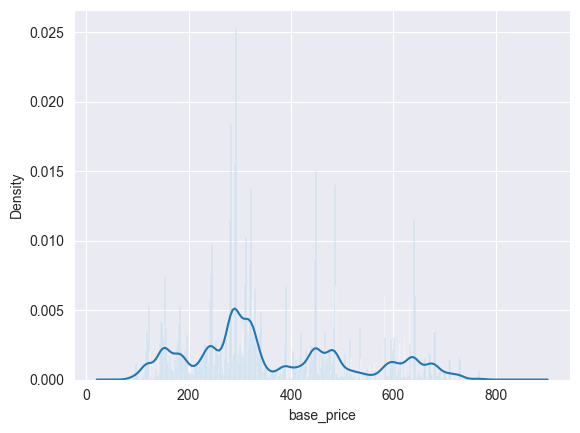

In [43]:
sns.distplot(main_data['base_price'].dropna(), bins=500)
plt.show()

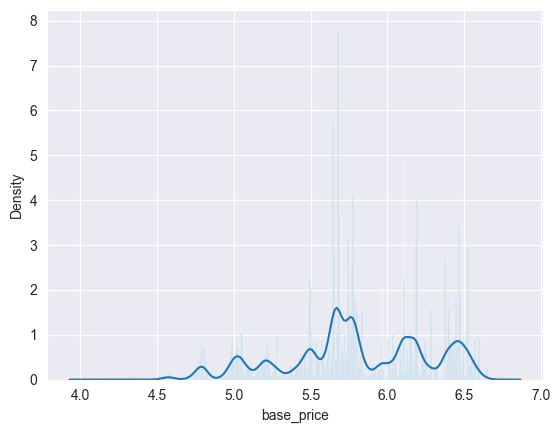

In [44]:
sns.distplot(np.log1p(main_data['base_price']).dropna(), bins=500)
plt.show()

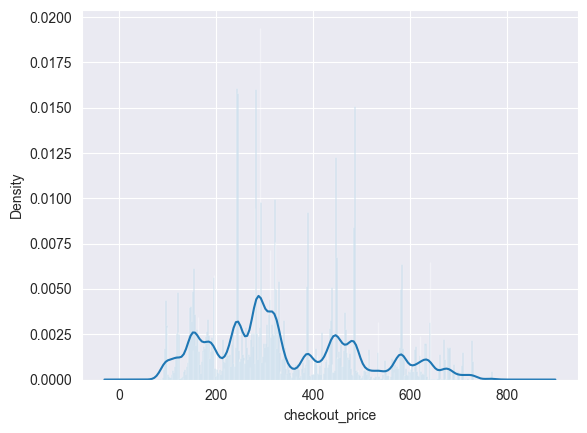

In [45]:
sns.distplot(main_data['checkout_price'].dropna(), bins=500)
plt.show()

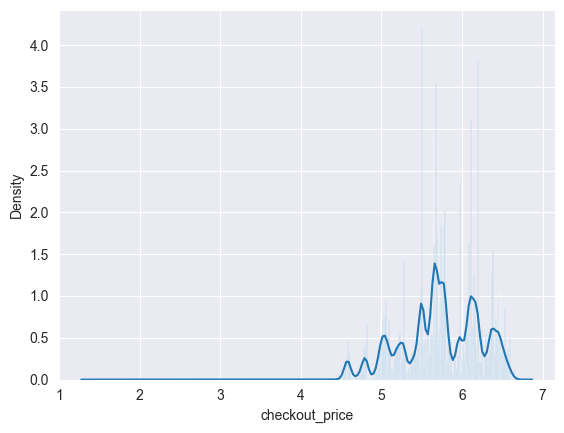

In [46]:
sns.distplot(np.log1p(main_data['checkout_price'].dropna()), bins=500)
plt.show()

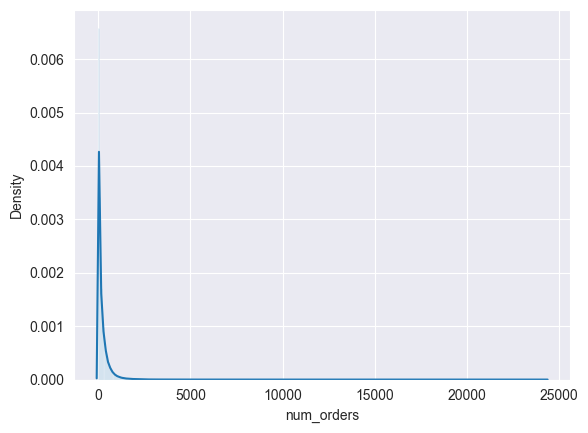

In [47]:
sns.distplot(main_data['num_orders'].dropna(), bins=500)
plt.show()

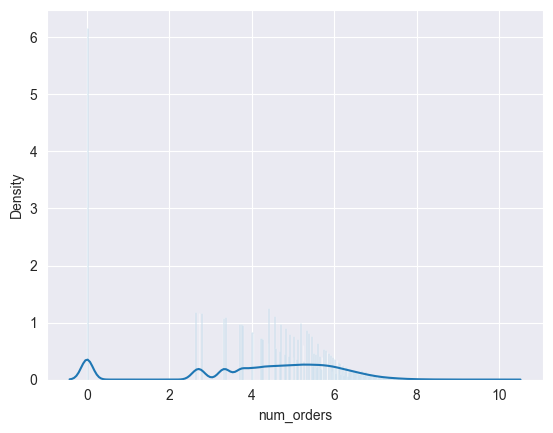

In [48]:
sns.distplot(np.log1p(main_data['num_orders'].dropna()), bins=500)
plt.show()

<Axes: xlabel='week'>

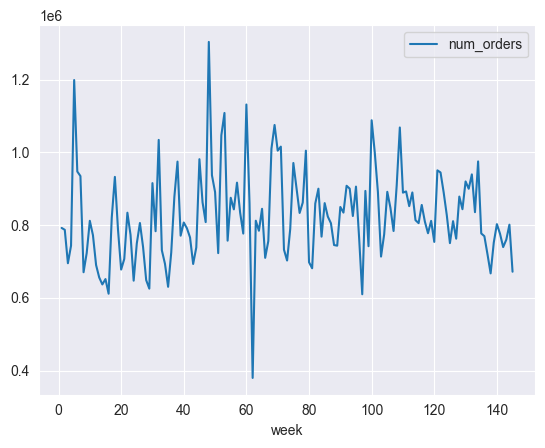

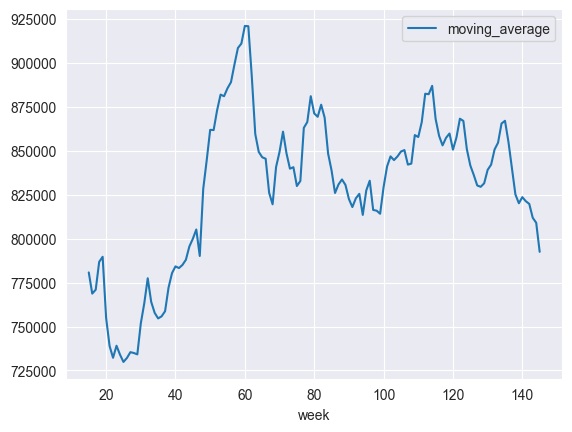

In [49]:
# Calculate the total num_orders per week
weekly_orders = main_data.groupby(['week'])['num_orders'].sum().reset_index()

# Calculate the moving average
weekly_orders['moving_average'] = weekly_orders['num_orders'].rolling(window=15).mean()

# Plot the num_orders and moving average
weekly_orders.plot(x='week', y='num_orders')
weekly_orders.plot(x='week', y='moving_average')

<Axes: xlabel='week'>

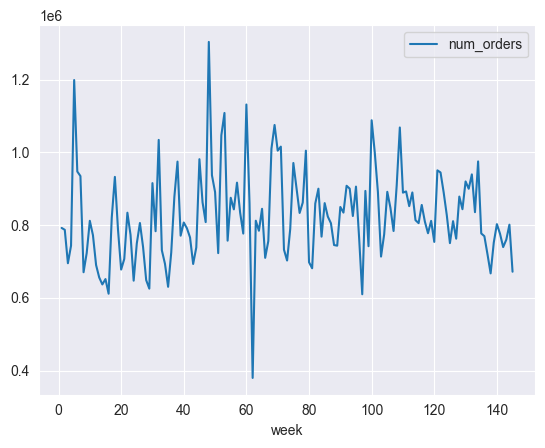

In [50]:
main_data.groupby(['week'])['num_orders'].sum().reset_index().plot(x='week', y='num_orders')

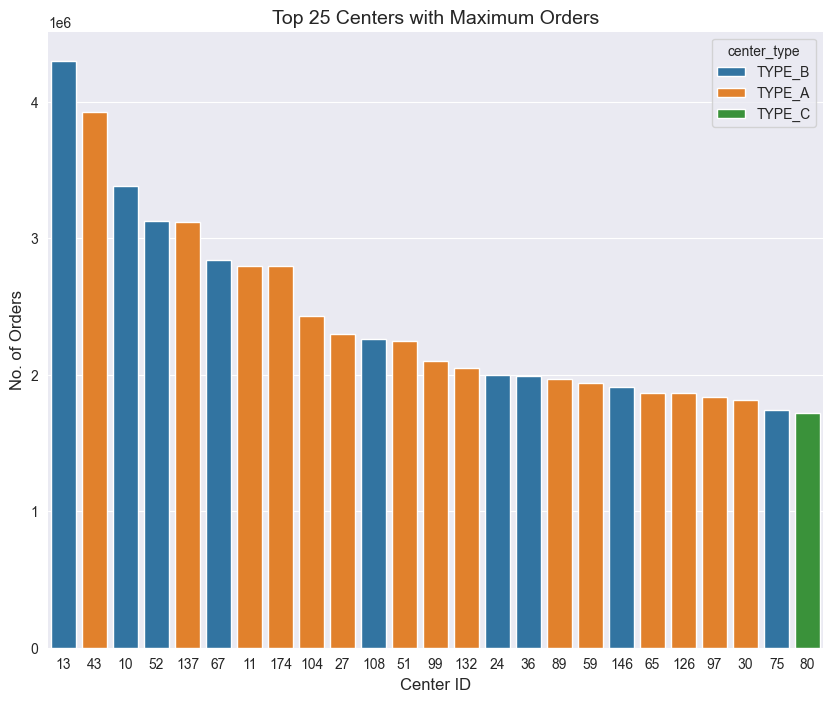

In [51]:
# plot of top 25 centers with maximum orders
fig = plt.figure(figsize=(10, 8))
plt.title('Top 25 Centers with Maximum Orders', fontdict={'fontsize': 14})
barlist = sns.barplot(y='num_orders', x='center_id',
                      data=main_data.groupby(['center_id', 'center_type']).num_orders.sum().sort_values(
                          ascending=False).reset_index().head(25), hue='center_type', order=list(
        main_data.groupby(['center_id', 'center_type']).num_orders.sum().sort_values(
            ascending=False).reset_index().head(25)['center_id']), dodge=False)
plt.ylabel('No. of Orders', fontdict={'fontsize': 12})
plt.xlabel('Center ID', fontdict={'fontsize': 12})
sns.despine(bottom=True, left=True)

fig = barlist.get_figure()

<Axes: xlabel='checkout_price', ylabel='num_orders'>

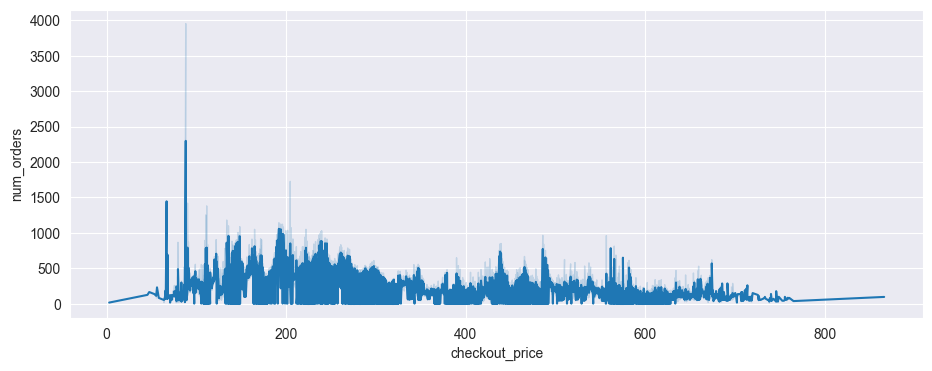

In [52]:
#plot of check_out price vs number of orders
fig = plt.figure(figsize=(11, 4))
sns.lineplot(x='checkout_price', y='num_orders', data=main_data)

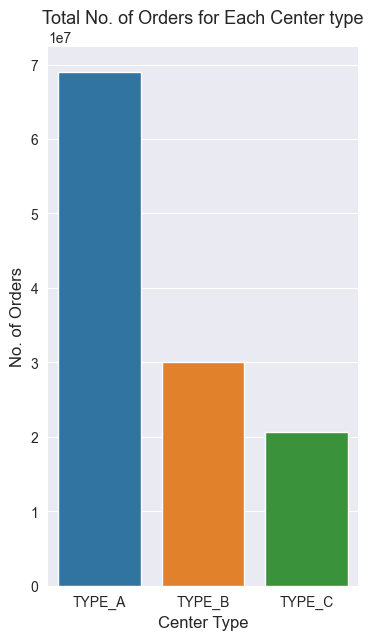

In [53]:
#plot of number of orders per center_type
fig = plt.figure(figsize=(4, 7))
plt.title('Total No. of Orders for Each Center type', fontdict={'fontsize': 13})
sns.barplot(y='num_orders', x='center_type', data=main_data.groupby('center_type').sum()['num_orders'].reset_index(),
            hue='center_type', dodge=False);
plt.ylabel('No. of Orders', fontdict={'fontsize': 12})
plt.xlabel('Center Type', fontdict={'fontsize': 12})
sns.despine(bottom=True, left=True)
plt.show()

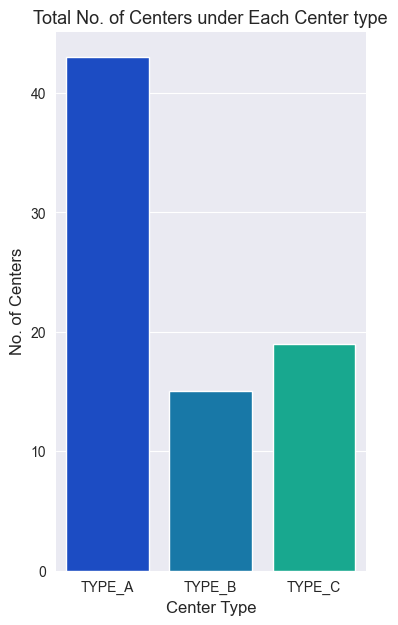

In [54]:
#plot of number of centers per center_type (A,B,C)
fig = plt.figure(figsize=(4, 7))
plt.title('Total No. of Centers under Each Center type', fontdict={'fontsize': 13})
sns.barplot(
    y=main_data.groupby(['center_id', 'center_type']).num_orders.sum().reset_index()['center_type'].value_counts(),
    x=main_data.groupby(['center_id', 'center_type']).num_orders.sum().reset_index()[
        'center_type'].value_counts().index, palette='winter', order=["TYPE_A", "TYPE_B", "TYPE_C"])
plt.ylabel('No. of Centers', fontdict={'fontsize': 12})
plt.xlabel('Center Type', fontdict={'fontsize': 12})
sns.despine(bottom=True, left=True)
plt.show()

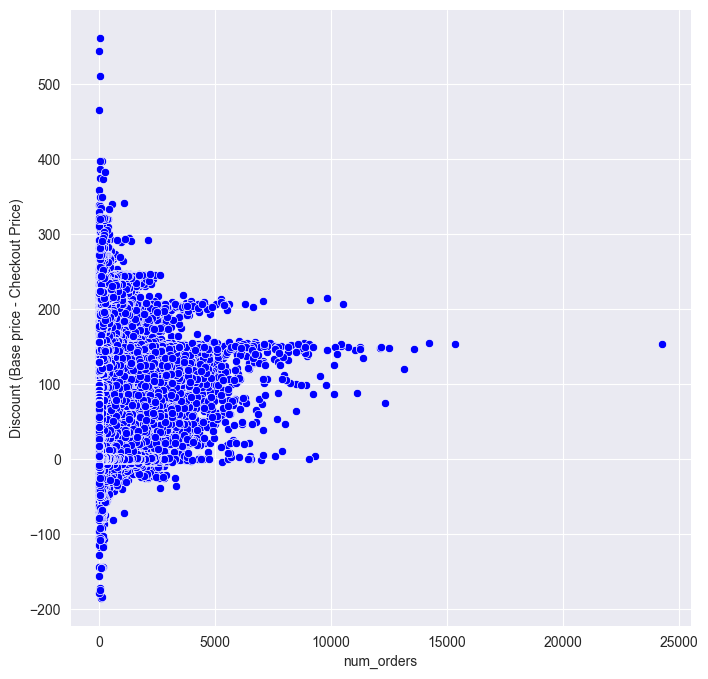

In [55]:
#plot of discount offered per week
plt.figure(figsize=(8, 8))
sns.scatterplot(y=main_data['base_price'] - main_data['checkout_price'], x=main_data['num_orders'], color='blue')
plt.ylabel('Discount (Base price - Checkout Price)')
sns.despine(bottom=True, left=True)
plt.show()

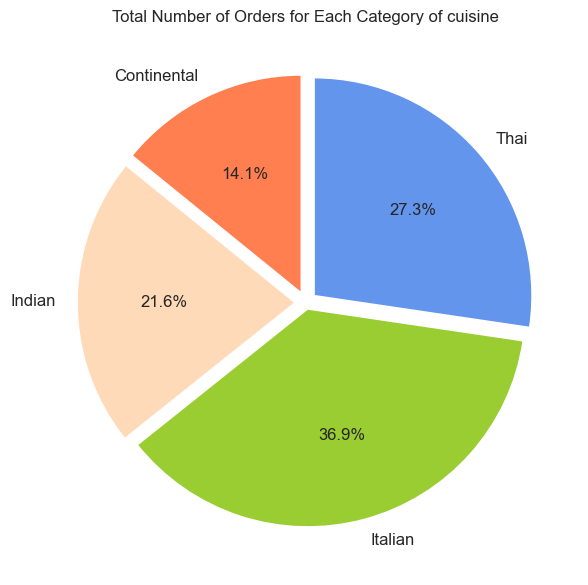

In [56]:
# plot of proportions of different cuisins ordered
plt.figure(figsize=(6, 6))
colors = ['coral', '#FFDAB9', 'yellowgreen', '#6495ED']
plt.pie(main_data.groupby(['cuisine']).num_orders.sum(),
        labels=main_data.groupby(['cuisine']).num_orders.sum().index,
        shadow=False, colors=colors, explode=(0.05, 0.05, 0.03, 0.05), startangle=90, autopct='%1.1f%%',
        pctdistance=0.6,
        textprops={'fontsize': 12})
plt.title('Total Number of Orders for Each Category of cuisine')
plt.tight_layout()
plt.show()

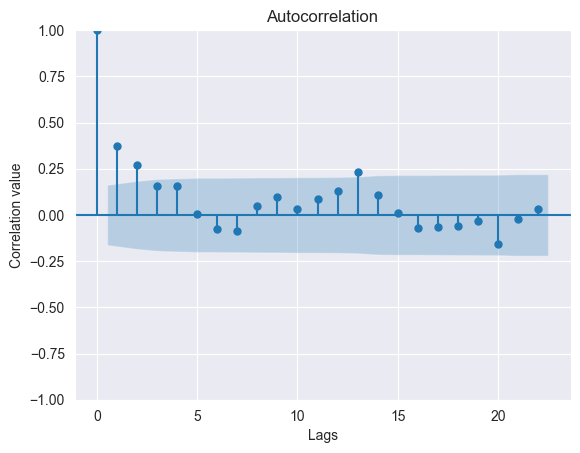

In [57]:
# Auto correlation plot of one meal id - center id combination 
time_slot = main_data[(main_data['meal_id'] == 1062) & (main_data['center_id'] == 10)]

sm.graphics.tsa.plot_acf(time_slot['num_orders'].values)
plt.xlabel('Lags')
plt.ylabel('Correlation value')
plt.show()